## Example of clustering visualization using sample data a slightly modified pyldavis.
* PyLDAVis is an open source package for visualizing topic distributions learned from an LDA model: https://github.com/bmabey/pyLDAvis
* Some open source code already exists to port over the visualizations produced by pyLDAvis to k-means models: https://github.com/lovit/kmeans_to_pyLDAvis
* This package is not pip installable, and a lot of the documentation seems to be in Korean. The code also seems to be geared to work with a specific k-means package. It's unclear if it works with scikit-learn k-means models
* Here, we'll take some of the relevant parts of the code (see the additional python file) and make some modifications to make it work with scikit-learn k-means

As a little refresher, the basic idea of cluserting is:

* Identify an object/instance i by its feature vector $X_{i} = <X_{i}^{1}, X_{i}^{2}, \ldots, X_{m}^{l}>$
* Define a distance function $d \left ( X_{i}, X_{j} \right )$ to measure the distance between $X_{i}$ and $X_{j}$.
* Create distinct groupings of instances that:
    * Minimize intra-group distances
    * Maximize inter-group distnace

In [19]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn import cluster
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [2]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500

In [24]:
# Set plot style
plt.style.use('ggplot')

In [4]:
# Import the data.  This comes from a survey conducted by one of my colleagues at SparkBeyond at a class they taught at
# NYU.  The data is student responses of their self scored proficency with certain subjects.  The goal will be to cluster
# the students by these responses.
d = pd.read_csv('survey_responses_2018.csv', header = 0, sep=',')
dpro = d[['profile_{}'.format(k + 1) for k in range(7)]]
dpro.columns = ['Viz', 'CS', 'Math', 'Stats', 'ML', 'Bus', 'Com']

In [5]:
dpro.head()

,Viz,CS,Math,Stats,ML,Bus,Com
0,2,2,2,5,0,3,6
1,4,9,7,7,6,3,8
2,7,5,4,3,2,9,9
3,7,7,5,4,1,6,8
4,7,6,8,8,4,6,7


In [29]:
# The subjects the students ranked themselves on are:
# Viz: for data visualization
# CS: for computer science
# Math: for pure math
# Stats: for statistics
# ML: for machine learning
# Bus: for business
# Com: for communications

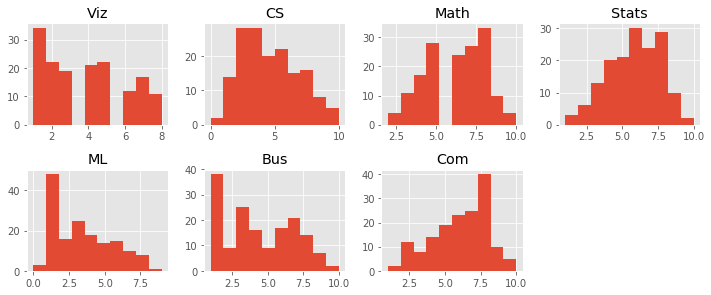

In [6]:
# We can take a look at the distribution of these responses
fig = plt.figure(figsize = (10, 6))
for i in range(7):
    plt.subplot(3, 4, i + 1)
    plt.hist(dpro[dpro.columns.values[i]])
    plt.title(dpro.columns.values[i])

fig.tight_layout()

In [15]:
# The important question here is, how correlated are the values to each other? 
# First look at the diffeent categories.

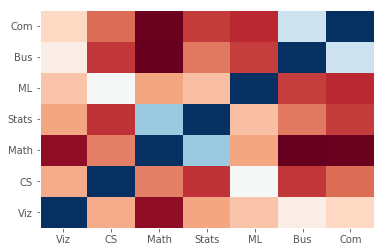

,Viz,CS,Math,Stats,ML,Bus,Com
Viz,1.000000,0.282906,0.015144,0.270820,0.328538,0.437584,0.368496
CS,0.282906,1.000000,0.215316,0.101657,0.481906,0.107712,0.185016
Math,0.015144,0.215316,1.000000,0.670016,0.272858,-0.044132,-0.037995
Stats,0.270820,0.101657,0.670016,1.000000,0.321812,0.201824,0.114225
ML,0.328538,0.481906,0.272858,0.321812,1.000000,0.117302,0.083175
Bus,0.437584,0.107712,-0.044132,0.201824,0.117302,1.000000,0.589699
Com,0.368496,0.185016,-0.037995,0.114225,0.083175,0.589699,1.000000


In [8]:
c_mat = dpro.corr()

fig, ax = plt.subplots()
heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)

#Set the tick labels and center them
ax.set_xticks(np.arange(c_mat.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(c_mat.shape[1])+0.5, minor=False)
ax.set_xticklabels(c_mat.index.values, minor=False)
ax.set_yticklabels(c_mat.index.values, minor=False)
plt.show()
c_mat

In [17]:
# So business and communications are highly correlated with each other.  So are Math and stats.  
# But math and business or communications not so highly correlated, same with stats. 
# Suggests segments might exist within this population.

In [20]:
# we can try to choose k by figuring out which value minimizes the within cluster sum of squares.  This is called inertia

In [21]:
km = cluster.KMeans(n_clusters=2, init='k-means++', n_init=5)
km.fit(dpro)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=5, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
inert_k = []
sil_k = []

for k in range(2, 20):
    km = cluster.KMeans(n_clusters=k, init='k-means++', n_init=5)
    km.fit(dpro)
    inert_k.append(km.inertia_)
    sil_k.append(metrics.silhouette_score(dpro, km.labels_, metric='euclidean'))

Text(0.5,1,'Silhoette Coefficient by k')

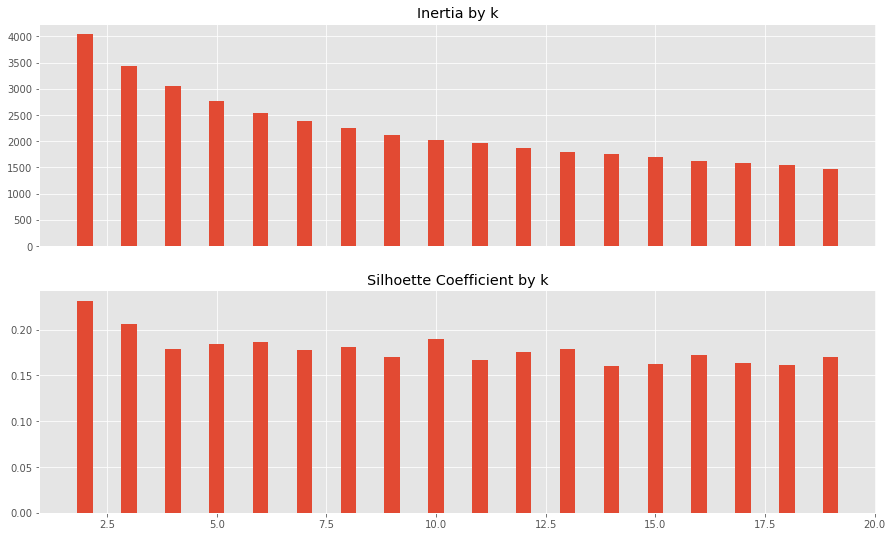

In [25]:
fix = plt.figure(figsize = (15, 9))
ax1 = plt.subplot(211)
plt.bar(range(2,20), inert_k, 0.35)
plt.title('Inertia by k')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1 = plt.subplot(212)
plt.bar(range(2,20), sil_k, 0.35)
plt.title('Silhoette Coefficient by k')

In [26]:
# So as k increase, the inertia ALWAYS decreases (as it should in general).
# The silhoette coefficient though is small.  Values close to zero indicate the clusters are dense and not well separated.  So these aren't good clusters. 
# The way you compute the silhoette score is as follows:

For each sample in the dataset:
* a = compute the mean distance between the sample and all other points in the same class.
* b = compute the mean distance between a sample and all other points in the next nearest cluster
* The silhoette coefficient is then given by:
    $s = \frac{b-a}{\max(a,b)}$
* The silhoette coefficient for a set of samples is given as the mean of the silhoette coefficient for each sample 

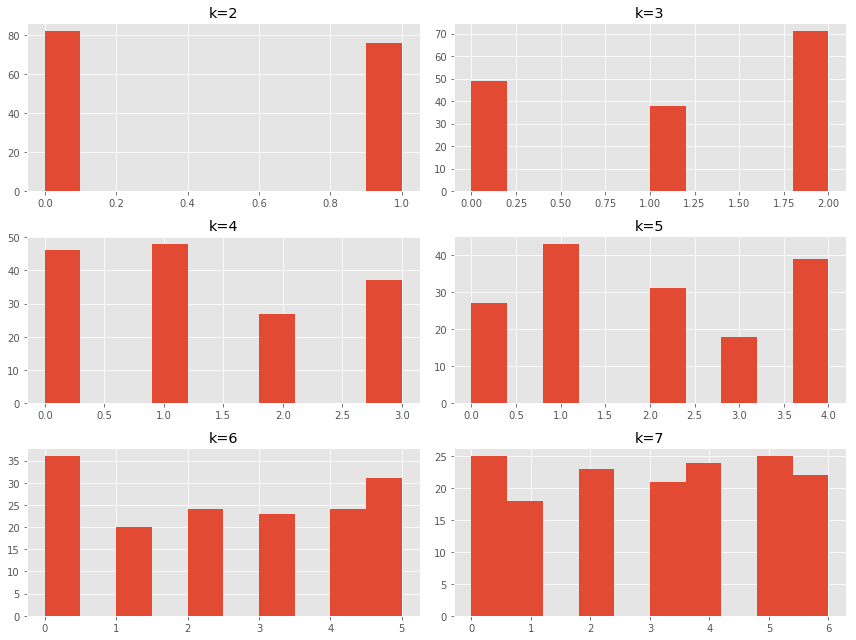

In [28]:
# Look at the distribution of clusters

fig = plt.figure(figsize = (12, 9))
for k in range(2, 8):
    km = cluster.KMeans(n_clusters = k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    ax = fig.add_subplot(3, 2 , k - 1)
    plt.hist(km.labels_)
    plt.title('k={}'.format(k))

fig.tight_layout()

plt.show()

This doesn't directly tell us what the right number of clusters is, but if we have an idea of what we are looking for,
this can at least tell us if we have a hope of getting some sensible the output.
Imagine now that we wanted to assign students to work together on a project.  We'll define a group as having 4 students.
Furthermore, we'd like to assign students to groups in order to maximize the diversity of a group.  That is, we'd like
to pick the students so that each one of the 4 represent a different skill set.  Based on this, what we're looking for
is 4 clusters.  The plots above suggest that k = 4 should give us something reasonably separable.  However, we still
don't really know what the clusters will be.  We can try and interpret them based on plotting the distribution of
features (in this case, scores by subject) within each cluster

In [30]:
km = cluster.KMeans(n_clusters=4, init='k-means++', n_init=10)
km.fit(dpro)
cols = ['r', 'y', 'b', 'g']

In [42]:
# We'll need to generate the actual predicted cluster labels here for our
# data.  I'll make a copy of the original dataframe and add these.  You
# could always just add these to the original dataframe as well if you'd
# like.
preds = dpro.copy()
preds['cluster'] = km.predict(dpro)

In [44]:
# The column cluster contains the predicted cluster for each student (row)
preds.head()

,Viz,CS,Math,Stats,ML,Bus,Com,cluster
0,2,2,2,5,0,3,6,1
1,4,9,7,7,6,3,8,2
2,7,5,4,3,2,9,9,0
3,7,7,5,4,1,6,8,0
4,7,6,8,8,4,6,7,2


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


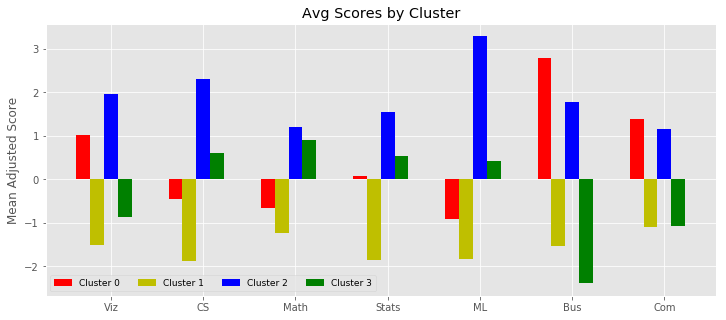

In [31]:
fig = plt.figure(figsize = (12, 5))
for i, cc in enumerate(km.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1, 1, 1)
    plt.bar(np.arange(len(cc)) + i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})

Here, aach coloured bar represents a cluster, and each grouping along the x-axis represents one of the subjects. 
On the y-axis, we plot the centre coordinates of each cluster, for each subject, 
with the mean score be subject subtracted. This provides a measure of how far along each of subject "axes" we are compared to the average across the entire dataset. A large value means that this cluster contains more examples from a subject than you might otherwise expect from the average population.  Similarly, a negative value indicates the opposite; the cluster does not tell us about this particular subject. i.e. the students in this cluster do not have the skill in question.

# Examining this plot, we can get a sense of what each cluster is about:
* Cluster 0: Students who are very strong in business and communications
* Cluster 1: Students who report themselves as being very low in all skills (or maybe just those who lack self confidence?)
* Cluster 2: Students who report themselves as good at pretty much everything (maybe over confident!)
* Cluster 3: Science student. They are good at pure and applied math/computer science, but not at all comfortable with business or communications.

Of course, these interpretations are somewhat arbitrary, but this is how you could start to label the individual clusters.

## Visualize with modified pyLDAvis.
* Here we'll take more explicit look at a way to visualize what's in each cluster and get sense of how well separated they are by projecting the higher dimensional clusters down to two dimensions (here, using t-SNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [45]:
# Move these imports up at the end
import pyLDAvis
from collections import Counter

In [38]:
# Import the custom module
import kmeans_vis

In [127]:
# Reload kmeans_vis if you add any functions to it
reload(kmeans_vis)

<module 'kmeans_vis' from 'kmeans_vis.py'>

In [107]:
# Now we need to run a few things here.
# We need to get the centres of the clusters.
centres = km.cluster_centers_
# We need the cluster sizes. The size is literally the count of of the
# predicted clusters in our data
labels = preds['cluster']
cluster_size = Counter(labels)
# Convert this to an array
cluster_size = np.asarray([cluster_size.get(c, 0) for c in range(n_clusters)])
# We need the cluster radius. This is an arbitrary value which is used to
# scale the coordinates for the visualization. 
# You can play around with this value to see what the effect is.
radius = 3.5
# We need the embedding method (here we'll use t-SNE, you can use pca here also by setting this to 'pca')
embedding_method = 'tsne'

In [108]:
# Now we need to generate the cluster coordinates in our two dimensional
# projection
cluster_coordinates = kmeans_vis._get_cluster_coordinates(centres=centres, 
                                                          cluster_size=cluster_size, 
                                                          radius=radius, 
                                                          embedding_method=embedding_method)

In [109]:
# Next we need to get some additional cluster info.  You may see some
# left over language from pyLDAvis about topics. The topics are just the
# clusters here.

In [110]:
# We need the predictor frequency.  This is literally the frequency of 
# each of the variables in our dataset
predictor_frequency = np.asarray(dpro.values.sum(axis=0)).reshape(-1)

In [111]:
predictor_frequency

array([608, 657, 976, 929, 530, 684, 974])

In [112]:
# The plotting won't work if we have a zero in here (we don't in this 
# case, but in the unlikely event that this happens, replace it with a
# number way smaller than anything else)
predictor_frequency[np.where(predictor_frequency == 0)[0]] = 0.01

In [113]:
# Next, we need the weighted centres. This is just the cluster centres
# weighted by the number of observations per cluster
n_observations, n_predictors = dpro.values.shape
n_clusters = centres.shape[0]
weighted_centres = np.zeros((n_clusters, n_predictors))
for c, n_observations in enumerate(cluster_size):
    weighted_centres[c] = centres[c] * n_observations

In [114]:
weighted_centres

array([[214., 163., 243., 262., 107., 313., 332.],
       [ 91.,  89., 193., 157.,  59., 109., 198.],
       [163., 181., 207., 208., 186., 171., 205.],
       [140., 224., 333., 302., 178.,  91., 239.]])

In [115]:
# We'll want to define the number of candidate features to print in the
# visualization. You can change this by adjusting:
n_candidate_words = 50

In [120]:
# Finally, in NLP applications you frequently produce an index2word 
# mapping.  This is just a map between the words in your corpus, and a
# unique identifier index. In this case, we can just use the name of the 
# columns used for clustering.

In [117]:
cluster_info = kmeans_vis._get_cluster_info(centres=centres, 
                                            cluster_size=cluster_size, 
                                            weighted_centres=weighted_centres, 
                                            term_frequency=predictor_frequency, 
                                            n_candidate_words=n_candidate_words,
                                            index2word=dpro.columns.tolist())

In [123]:
# Now we need to generate a cluster table
cluster_table = kmeans_vis._get_cluster_table(weighted_centres=weighted_centres, 
                                              cluster_info=cluster_info, 
                                              index2word=dpro.columns.tolist())

In [128]:
# convert to pandas.DataFrame
cluster_coordinate_df = kmeans_vis._df_cluster_coordinate(cluster_coordinates)
cluster_info_df = kmeans_vis._df_cluster_info(cluster_info)
cluster_table_df = kmeans_vis._df_cluster_table(cluster_table)

In [129]:
# There are few parameters we need to set within pyLDAvis
n_printed_words = 30
lambda_step = 0.01

In [132]:
# We also need to pass a cluster order.  In this, we order by size.
cluster_order = cluster_size.argsort()[::-1].tolist()

In [133]:
cluster_order

[3, 0, 1, 2]

In [135]:
# Finally, we need to set the plot options.  This is the type of 
# projection we are going to use along the two directions.  We've selected
# t-sne here.
if embedding_method == 'pca':
    plot_opts={'xlab': 'PCA1', 'ylab': 'PCA2'}
else:
    plot_opts={'xlab': 't-SNE1', 'ylab': 't-SNE2'}

In [136]:
# ready pyLDAvis.PreparedData
prepared_data = pyLDAvis.PreparedData(cluster_coordinate_df,
                                      cluster_info_df,
                                      cluster_table_df,
                                      n_printed_words,
                                      lambda_step,
                                      plot_opts,
                                      cluster_order)

In [137]:
pyLDAvis.display(prepared_data)

So let's see if this corresponds with what we found in the earlier plot of mean adjusted score in the clusters:
* Cluster 1: Heavier on communications and business (this is cluster 0 above)
* Cluster 2: Students who have ranked themselves low on everything (cluster 1 above)
* Cluster 3: Students who have ranked themselves higher on everything (cluster 2 above)
* Cluster 4: Science students (cluster 3 above)

In [ ]:
# You can export this as: